# **Exploratory Data Analysis**

Import Packages

In [25]:
import pandas as pd
pd.set_option('display.width', 1000)

import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import nasdaqdatalink

# Machine Learning Models
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
    VotingRegressor, StackingRegressor, BaggingRegressor
)
import xgboost as xgb
from xgboost import XGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

#--- Starting Here ---#

In [26]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [75]:
NVDA = 'NVDA'
SEMICONDUCTORS = ["TSM", "AVGO", "AMD", "ASML", "MRVL", "ON"]
scaler = MinMaxScaler(feature_range=(0, 1)) # Scaling RSI values for more relatable trends

semiConductor_data = yf.download(NVDA, start='2010-01-01', end='2024-01-01')
semiConductor_data.columns = [col[0] for col in semiConductor_data.columns]
semiConductor_data['Ticker'] = NVDA
semiConductor_data['RSI'] = calculate_rsi(semiConductor_data['Close'], window=14)
semiConductor_data['RSI_Scaled'] = scaler.fit_transform(semiConductor_data['RSI'].values.reshape(-1, 1))
semiConductor_data.reset_index(inplace=True)
semiConductor_data = semiConductor_data[['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled']]

#print(f"Total Data Length: {len(semiConductor_data)}")

for stock in SEMICONDUCTORS:
    stock_data = yf.download(stock, start="2010-01-01", end="2024-01-01")

    stock_data['Ticker'] = stock
    stock_data['RSI'] = calculate_rsi(stock_data['Close'], window=14)
    stock_data['RSI_Scaled'] = scaler.fit_transform(stock_data['RSI'].values.reshape(-1, 1))
    stock_data.reset_index(inplace=True)
    #stock_data = stock_data[['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled']]
    stock_data.columns = [col[0] for col in stock_data.columns]

    semiConductor_data = pd.concat([stock_data, semiConductor_data], ignore_index=True)

    #print([val[0] for val in semiConductor_data.columns.tolist()])
    #print(f"Total Data Length: {len(semiConductor_data)}")

semiConductor_data = semiConductor_data.dropna()
semiConductor_data.to_csv("semiconductorData.csv", index=False)
print([ i for i in semiConductor_data['Ticker'].unique()])
for stock in SEMICONDUCTORS + [NVDA]:
    print(f"{stock} rows: {len(semiConductor_data.loc[semiConductor_data['Ticker'] == stock])}")

print(semiConductor_data.columns)
semiConductor_data.drop(columns=['Date'], inplace=True)
print(semiConductor_data.dtypes)
semiConductor_data.head(5)


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['ON', 'MRVL', 'ASML', 'AMD', 'AVGO', 'TSM', 'NVDA']
TSM rows: 3509
AVGO rows: 3509
AMD rows: 3509
ASML rows: 3509
MRVL rows: 3509
ON rows: 3509
NVDA rows: 3509
Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled'], dtype='object')
Close         float64
High          float64
Low           float64
Open          float64
Volume          int64
Ticker         object
RSI           float64
RSI_Scaled    float64
dtype: object


,Close,High,Low,Open,Volume,Ticker,RSI,RSI_Scaled
13,7.67,8.06,7.62,8.06,13017500,ON,21.962626,0.179946
14,7.92,8.02,7.74,7.76,10853300,ON,30.125530,0.265726
15,7.88,7.96,7.74,7.85,7781900,ON,30.638304,0.271114
16,7.94,8.01,7.75,7.88,8462600,ON,29.130450,0.255269
17,7.44,7.99,7.29,7.99,20256200,ON,24.014345,0.201507


In [92]:
class lstmDataset(Dataset):
    def __init__(self, data, features, targets, input_window=15, output_window=10):
        self.data = torch.FloatTensor(data.values) # 2 dimensional array with each array being all the features in a data point
        self.input_window = input_window
        self.output_window = output_window
    
    def __len__(self):
        # Returns the total number of samples that can be generated.
        return len(self.data) - self.input_window - self.output_window + 1
    
    def __getitem__(self, idx):
        #Generates a single sample of data.
        #Args:
        #    idx (int): Index for the sample.
        #Returns:
        #    Tuple[torch.Tensor, torch.Tensor]: Input and output tensors.
        x = self.data[idx : idx + self.input_window] # Gets the 15 values we're using for predictions
        y = self.data[idx + self.input_window : idx + self.input_window + self.output_window][7] # Gets the 10 values we're trying to predict
        return x, y

In [97]:
company_datasets = {}
tickers = semiConductor_data['Ticker'].unique()

# Create an lstmDataset for each company and store it in company_datasets
for ticker in tickers:
    data = semiConductor_data[semiConductor_data['Ticker'] == ticker].drop(columns=["Ticker"])
    company_datasets[ticker] = lstmDataset(data, input_window=15, output_window=10, features=features, targets=targets)
print(company_datasets)

batch_size = 32 
company_loaders = {}

for ticker, dataset in company_datasets.items():
    company_loaders[ticker] = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(company_loaders)

{'ON': <__main__.lstmDataset object at 0x000001D511877860>, 'MRVL': <__main__.lstmDataset object at 0x000001D50EDE4830>, 'ASML': <__main__.lstmDataset object at 0x000001D5118AE090>, 'AMD': <__main__.lstmDataset object at 0x000001D5118ACE90>, 'AVGO': <__main__.lstmDataset object at 0x000001D50FB2C680>, 'TSM': <__main__.lstmDataset object at 0x000001D5118ACAA0>, 'NVDA': <__main__.lstmDataset object at 0x000001D5118AE210>}
{'ON': <torch.utils.data.dataloader.DataLoader object at 0x000001D511A07FE0>, 'MRVL': <torch.utils.data.dataloader.DataLoader object at 0x000001D5118744A0>, 'ASML': <torch.utils.data.dataloader.DataLoader object at 0x000001D51189CE60>, 'AMD': <torch.utils.data.dataloader.DataLoader object at 0x000001D50FA56690>, 'AVGO': <torch.utils.data.dataloader.DataLoader object at 0x000001D5118AF8F0>, 'TSM': <torch.utils.data.dataloader.DataLoader object at 0x000001D5118AA7E0>, 'NVDA': <torch.utils.data.dataloader.DataLoader object at 0x000001D5118AB290>}


Define LSTM Model

In [98]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size, dropout=0.0):
        super(LSTMModel, self).__init__()
        layer1 = 64
        layer2 = 32
        layer3 = 16

        self.lstm1 = nn.LSTM(input_size=input_size, 
                             hidden_size=layer1, 
                             batch_first=True, 
                             dropout=0)
        
        self.lstm2 = nn.LSTM(input_size=layer1, 
                             hidden_size=layer2, 
                             batch_first=True, 
                             dropout=0)

        self.lstm3 = nn.LSTM(input_size=layer2, 
                             hidden_size=layer3, 
                             batch_first=True, 
                             dropout=0)
        
        self.fc = nn.Linear(layer3, output_size)
        
        # Activation functions
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.sigmoid(out)

        out, _ = self.lstm2(out)
        out = self.sigmoid(out)

        out, _ = self.lstm3(out)
        out = self.sigmoid(out)

        out = out[:, -1, :]  # Shape: [batch_size, hidden_size]
        
        out = self.fc(out)
        out = self.sigmoid(out)
        
        return out

In [101]:
epochs = 10  
model = LSTMModel(input_size=7, output_size=1)  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for ticker, loader in company_loaders.items():
    
    for epoch in range(epochs):
        for batch_idx, (x_batch, y_batch) in enumerate(loader):
            optimizer.zero_grad()

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch)

            loss.backward()

            optimizer.step()

            if batch_idx % 100 == 0:
                print(f"Company: {ticker}, Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")

c:\Users\lordw\OneDrive\Documents\Coding_Projects\AlgoTrAdInG\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 7])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Company: ON, Epoch: 0, Batch: 0, Loss: 7440984178688.0
Company: ON, Epoch: 0, Batch: 100, Loss: 12970950131712.0
Company: ON, Epoch: 1, Batch: 0, Loss: 7114153000960.0


c:\Users\lordw\OneDrive\Documents\Coding_Projects\AlgoTrAdInG\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([29, 7])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Company: ON, Epoch: 1, Batch: 100, Loss: 5973621604352.0
Company: ON, Epoch: 2, Batch: 0, Loss: 9461130330112.0
Company: ON, Epoch: 2, Batch: 100, Loss: 7222464610304.0
Company: ON, Epoch: 3, Batch: 0, Loss: 12177520984064.0
Company: ON, Epoch: 3, Batch: 100, Loss: 8863424184320.0
Company: ON, Epoch: 4, Batch: 0, Loss: 4672551649280.0
Company: ON, Epoch: 4, Batch: 100, Loss: 8672662519808.0
Company: ON, Epoch: 5, Batch: 0, Loss: 8911103983616.0
Company: ON, Epoch: 5, Batch: 100, Loss: 7785534193664.0
Company: ON, Epoch: 6, Batch: 0, Loss: 6677825323008.0
Company: ON, Epoch: 6, Batch: 100, Loss: 9719448076288.0
Company: ON, Epoch: 7, Batch: 0, Loss: 14293046132736.0
Company: ON, Epoch: 7, Batch: 100, Loss: 11754604068864.0
Company: ON, Epoch: 8, Batch: 0, Loss: 6947685793792.0
Company: ON, Epoch: 8, Batch: 100, Loss: 8185527140352.0
Company: ON, Epoch: 9, Batch: 0, Loss: 7865724567552.0
Company: ON, Epoch: 9, Batch: 100, Loss: 8061258825728.0
Company: MRVL, Epoch: 0, Batch: 0, Loss: 320

c:\Users\lordw\OneDrive\Documents\Coding_Projects\AlgoTrAdInG\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 7])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss after 100 batches: 8854016119275.52


c:\Users\lordw\OneDrive\Documents\Coding_Projects\AlgoTrAdInG\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([29, 7])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss after 200 batches: 12491147410145.28
Test Loss after 300 batches: 9720238766271.146
Test Loss after 400 batches: 97258323087728.64
Test Loss after 500 batches: 130277352453603.33
Test Loss after 600 batches: 123257163703391.58
Test Loss after 700 batches: 3431192156118267.5
Average Test Loss: 7275765042802468.0
Predictions for NVDA: [[0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]
 [0.9999976]]
True values for NVDA: [[5.4523784e-01 5.4933375e-01 5.3752786e-01 5.4017818e-01 2.4356000e+08
  7.2022247e+01 7.1584558e-01]
 [1.4804297e+01 1.5213401e+01 1.4755156e+01 1.5091917e+01 2.0391200e+08
  4.0185169e+01 3.8575837e-01]
 [5.864265

ValueError: x and y must be the same size

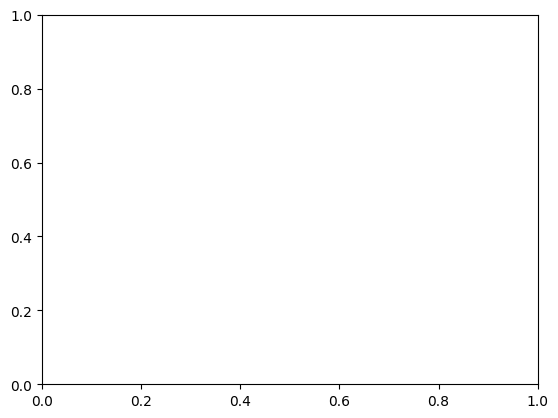

In [105]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
num_batches = 0

# Disable gradient computation for testing
with torch.no_grad():
    for ticker, loader in company_loaders.items():
        for x_batch, y_batch in loader:
            # Forward pass
            y_pred = model(x_batch)
            
            # Compute the loss
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
            num_batches += 1
            
            # Optionally, track or print predictions vs true values
            if num_batches % 100 == 0:  # Print every 100 batches (optional)
                print(f"Test Loss after {num_batches} batches: {test_loss / num_batches}")
                
# Calculate average test loss
avg_test_loss = test_loss / num_batches
print(f"Average Test Loss: {avg_test_loss}")

# If you want to evaluate the performance for a specific ticker (company)
ticker = "NVDA"  # Example: test for NVIDIA
for x_batch, y_batch in company_loaders[ticker]:
    # Perform prediction
    y_pred = model(x_batch)
    
    # Convert to numpy for easier inspection
    y_pred = y_pred.detach().numpy()
    y_batch = y_batch.numpy()
    
    # Visualize or compare predictions and true values
    print(f"Predictions for {ticker}: {y_pred}")
    print(f"True values for {ticker}: {y_batch}")
    plt.scatter(y_pred, y_batch)
plt.show()